# Flowchart-Detection model
## 1. Confirmation of environment

In [ ]:
!pip freeze

In [ ]:
# install related libraries
!pip install cairosvg
!apt install tree
!pip install xmltodict
!pip install albumentations
!pip install ultralytics

In [ ]:
# mount to g-drive
from google.colab import drive
drive.mount('/content/drive')

## 2. git clone damo-yolo model and locate in G-drive
- git clone damo-yolo model
```bash
git clone https://github.com/tinyvision/DAMO-YOLO.git
```
- in this notebook, I located it in /content/drive/MyDrive/programs/flow-chart-detection/

The following directory structure is assumed
```
/content/drive/MyDrive/programs/flow-chart-detection
├── ckpt
│   ├── damoyolo_tinynasL20_T_436.pth
│   └── ...
├── damo-yolo
│   ├── assets
│   ├── configs
│   │   ├── damoyolo_tinynasL20_T.py
│   │   ├── ...
├── ...
├── data_coco_format_start_end_train
│   ├── annotations
│   │   └── instances_custom.json
│   └── images
│       ├── flowchart-example001.webp
│       ├── ...
├── data_coco_format_start_end_test
│   ├── annotations
│   │   └── instances_custom.json
│   └── images
│       ├── flowchart-example002.webp
│       ├── ...
```



In [ ]:
!ls /content/drive/MyDrive/programs/flow-chart-detection/

In [6]:
# set path to dataaset
PATH_TO_FCDetection = '/content/drive/MyDrive/programs/flow-chart-detection'

In [ ]:
!tree /content/drive/MyDrive/programs/flow-chart-detection

## 3. load images and annotations

In [ ]:
!pip install cairosvg

In [8]:
# install libraries
from PIL import Image
import cairosvg
from io import BytesIO
import cv2
from IPython.display import display
import numpy as np
import os
import glob

In [ ]:
# load images and visualize them
files = glob.glob(os.path.join(PATH_TO_FCDetection, 'data', '*'))
print(f"files: {files}")
for path1 in files:
  if path1.rsplit('.', 1)[1] == 'xml' or path1.rsplit('.', 1)[1] == 'txt':
    continue
  if path1.rsplit('.', 1)[1] == 'svg':
    img = cairosvg.svg2png(url=path1)
    img = Image.open(BytesIO(img))
  else:
    img = Image.open(path1).convert('RGB')
  print("type(img), ", type(img))
  print("img.size, ", img.size)
  # img = cv2.imread(path1)
  display(img)

In [ ]:
# load annotations
files = glob.glob(os.path.join(PATH_TO_FCDetection, 'data_from_unicharm', '*'))
print(f"files: {files}")
import xml.etree.ElementTree as ET
for path1 in files:
  if path1.rsplit('.', 1)[1] != 'xml':
    continue
  tree = ET.parse(path1)
  root = tree.getroot()
  for child in root:
    print(child.tag, child.attrib)

In [ ]:
!pip install xmltodict

In [ ]:
# draw bbox into images
from PIL import ImageDraw
import xmltodict
# xmlのみ収集
xml_files = []
files = glob.glob(os.path.join(PATH_TO_FCDetection, 'data_from_unicharm', '*'))
for path1 in files:
  if path1.rsplit('.', 1)[1] == 'xml':
    xml_files.append(path1)
print('xml_files', xml_files)

# xmlファイルから対応する画像ファイルを読み込む
for xml_path1 in xml_files:
  # get image path... png, jpg, jpeg, ...etc
  # img_path_base = xml_path1.rsplit('.', 1)[0]
  # files = glob.glob(os.path.join(PATH_TO_FCDetection, 'data', img_path_base + '.*'))
  # img_file_name = None
  # for path1 in files:
  #   if path1.rsplit('.', 1)[1] != 'xml':
  #     img_file_name = path1

  with open(xml_path1, 'r') as f:
      xml_string = f.read()
  xml_dict = xmltodict.parse(xml_string)

  colors = {'terminator':"red",
            'process':"green",
            'decision':"#808080",
            'arrow':"#FFA500",
            'text':"blue",
            'arrow_start':"#800080",
            'data':"grey",
            'connection':"black",
            'arrow_end':"yellow",}

  anno_dict = xml_dict['annotation']
  # open image
  filename = anno_dict['filename']
  file_path = os.path.join(PATH_TO_FCDetection, 'data_from_unicharm', filename)
  print("file_path, ", file_path)
  # if filename.rsplit('.', 1)[1] == 'gif':
  img = Image.open(file_path).convert('RGB')
  # else:
  #   img = Image.open(file_path)
  print("type(img), ", type(img))
  print("img.size, ", img.size)
  # ImageDrawオブジェクトの作成
  draw = ImageDraw.Draw(img)

  for key, value in anno_dict.items():
    if key == 'object':
      for object1 in value:
        print("object1, ", object1)
        xmin = int(object1['bndbox']['xmin'])
        ymin = int(object1['bndbox']['ymin'])
        xmax = int(object1['bndbox']['xmax'])
        ymax = int(object1['bndbox']['ymax'])

        # 矩形の描画
        # (x1, y1)は左上の座標、(x2, y2)は右下の座標
        print("")
        draw.rectangle((xmin, ymin, xmax, ymax), outline=colors[object1['name']],
                       width=3) # fill=colors[object1['name']],

  # 画像の保存
  # img.save('rectangle.png')
  display(img)



# 4. Model building and learning

In [11]:
# import torch, else
import xml.etree.ElementTree as ET
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.models.detection import fcos_resnet50_fpn
from torchvision.models.detection.fcos import FCOSHead
import cv2
import numpy as np
from PIL import Image
import xmltodict
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os

In [ ]:
# If necessary, pre-process annotations
LABELS = {'text':0,
          'arrow':1,
          'connection':2,
          'data':3,
          'decision':4,
          'process':5,
          'terminator':6}


def convert_xml_to_yolo(xml_dir, output_dir, image_dir):
    os.makedirs(output_dir, exist_ok=True)
    xml_files = [f for f in os.listdir(xml_dir) if f.endswith('.xml')]

    for xml_file in xml_files:
        # XMLファイルを読み込み
        tree = ET.parse(os.path.join(xml_dir, xml_file))
        root = tree.getroot()

        # 画像情報を取得
        filename = root.find('filename').text
        img_path = os.path.join(image_dir, filename)
        img_width = int(root.find('size/width').text)
        img_height = int(root.find('size/height').text)

        # 出力先ファイル名
        output_txt_path = os.path.join(output_dir, os.path.splitext(filename)[0] + '.txt')

        # バウンディングボックスを変換
        with open(output_txt_path, 'w') as f:
            for obj in root.findall('object'):
                class_name = obj.find('name').text
                if class_name not in LABELS:
                    continue  # 定義されていないクラスはスキップ
                class_id = LABELS[class_name]
                bndbox = obj.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)

                # YOLO形式に変換
                x_center = (xmin + xmax) / 2 / img_width
                y_center = (ymin + ymax) / 2 / img_height
                width = (xmax - xmin) / img_width
                height = (ymax - ymin) / img_height

                # 書き込み
                f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

        print(f"Converted {xml_file} to {output_txt_path}")

# パスの設定
# xml_dir = os.path.join(PATH_TO_FCDetection, 'data')  # XMLファイルのディレクトリ
xml_dir = os.path.join(PATH_TO_FCDetection, 'data_from_unimedia')
output_dir = os.path.join(PATH_TO_FCDetection, 'data_yolo')  # YOLO形式アノテーションの出力先
image_dir = os.path.join(PATH_TO_FCDetection, 'data_from_unimedia')  # 画像が格納されているディレクトリ

# 実行
# convert_xml_to_yolo(xml_dir, output_dir, image_dir) # damo-yoloでは実行せず

In [ ]:
!ls drive/MyDrive/programs/flow-chart-detection/damo-yolo/
!pwd

In [ ]:
%cd /content/drive/MyDrive/programs/flow-chart-detection/damo-yolo
!pip install -r requirements.txt
import os
os.environ['PYTHONPATH'] = f"{os.getcwd()}:{os.environ.get('PYTHONPATH', '')}"

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo')
print("sys.path ", sys.path)
!export PYTHONPATH="$PYTHONPATH:/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo"
!echo $PYTHONPATH
!ls


In [ ]:
# Create symbolic links
# ex)
!ln -s /content/drive/MyDrive/programs/flow-chart-detection/data_coco_format_start_end_test /content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/datasets/custom_coco_test

In [ ]:
!nvidia-smi

In [ ]:
# do fine-tuning. for detail, see damo-yolo official site.
# ex)
!torchrun --nproc_per_node=1 tools/train.py -f configs/damoyolo_tinynasL20_T.py --local_rank 0 --tea_ckpt /content/drive/MyDrive/programs/flow-chart-detection/ckpt/damoyolo_tinynasL20_T_436.pth

In [ ]:
!ls /content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/workdirs/damoyolo_tinynasL20_T/epoch_3000_ckpt.pth

Number of epochs: 1244
Number of AP values: 1244
Number of AR values: 1866


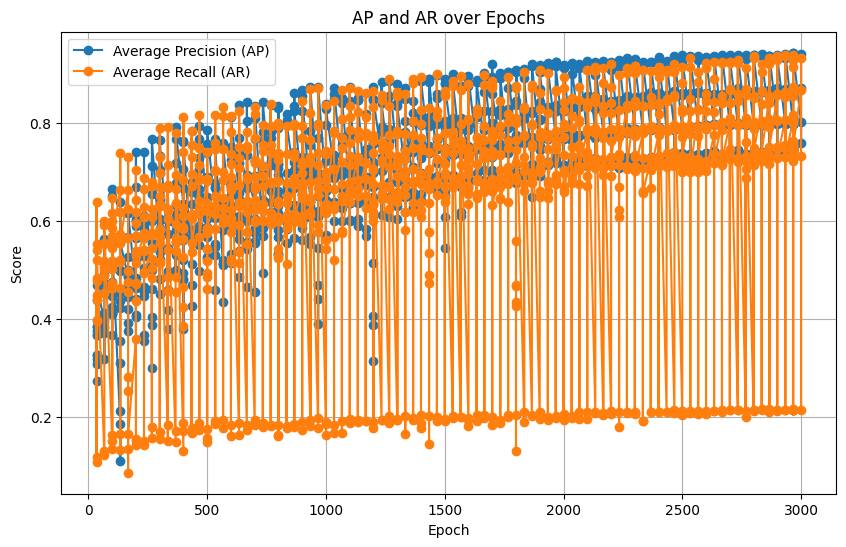

In [20]:
# visualize results
import re
import matplotlib.pyplot as plt

# read files
file_path = '/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/workdirs/damoyolo_tinynasL20_T/2025-04-23-1819'

with open(file_path, 'r') as file:
    lines = file.readlines()

# APとARの抽出
epochs = []
ap_values = []
ar_values = []
current_epoch = None  # current_epochを初期化

for line in lines:
    # エポック情報を抽出
    epoch_match = re.search(r'epoch: (\d+)/', line)
    if epoch_match:
        current_epoch = int(epoch_match.group(1))

    # current_epochが定義されているかを確認
    if current_epoch is not None:
        # APを抽出
        ap_match = re.search(r'Average Precision\s+\(AP\)\s+@\[\s*IoU=0\.50:0\.95.*=\s+([\d\.]+)', line)
        if ap_match:
            ap_values.append(float(ap_match.group(1)))
            epochs.append(current_epoch)  # APが追加されるときだけエポックを追加

        # ARを抽出
        ar_match = re.search(r'Average Recall\s+\(AR\)\s+@\[\s*IoU=0\.50:0\.95.*=\s+([\d\.]+)', line)
        if ar_match:
            ar_values.append(float(ar_match.group(1)))

# デバッグ用: データの長さを確認
print(f"Number of epochs: {len(epochs)}")
print(f"Number of AP values: {len(ap_values)}")
print(f"Number of AR values: {len(ar_values)}")

# データ数が一致しない場合の調整
min_length = min(len(epochs), len(ap_values), len(ar_values))
epochs = epochs[:min_length]
ap_values = ap_values[:min_length]
ar_values = ar_values[:min_length]

# グラフの作成
plt.figure(figsize=(10, 6))
plt.plot(epochs, ap_values, label='Average Precision (AP)', marker='o')
plt.plot(epochs, ar_values, label='Average Recall (AR)', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('AP and AR over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# test phase
import json
import cv2
import matplotlib.pyplot as plt
import os

# set path
image_dir = '/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/datasets/custom_coco_train/images/'
annotation_path = '/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/datasets/custom_coco_train/annotations/instances_custom.json'

# アノテーションの読み込み
with open(annotation_path, 'r') as f:
    data = json.load(f)

# 画像情報とアノテーションを取得
image_info = data["images"][:10]  # 最初の10枚を選択
annotations = data["annotations"]
categories = {cat["id"]: cat["name"] for cat in data["categories"]}  # カテゴリ名辞書

# 画像IDと対応するアノテーションをマッピング
image_id_to_annotations = {}
for ann in annotations:
    image_id = ann["image_id"]
    if image_id not in image_id_to_annotations:
        image_id_to_annotations[image_id] = []
    image_id_to_annotations[image_id].append(ann)

# 画像の読み込みと描画
for img_info in image_info:
    img_path = os.path.join(image_dir, img_info["file_name"])
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # バウンディングボックスの描画
    if img_info["id"] in image_id_to_annotations:
        for ann in image_id_to_annotations[img_info["id"]]:
            x, y, w, h = ann["bbox"]
            category_name = categories.get(ann["category_id"], "Unknown")

            # クラスによって色を変更
            # if ann["category_id"] in [8, 9]:  # arrow_start と arrow_end
            #     color = (0, 0, 255)  # 青色 (BGR)
            # else:
            #     color = (255, 0, 0)  # 赤色 (BGR)
            if ann["category_id"] == 8:  # arrow_start
                color = (0, 0, 255)  # 青色 (BGR)
            elif ann["category_id"] == 9:  # arrow_end
                color = (0, 255, 0)  # 青色 (BGR)
            else:
                color = (255, 0, 0)  # 赤色 (BGR)

            # バウンディングボックスを描画
            cv2.rectangle(image, (int(x), int(y)), (int(x + w), int(y + h)), color, 2)

            # ラベルを表示
            cv2.putText(image, category_name, (int(x), int(y) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    # 画像を表示
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.title(img_info["file_name"])
    plt.show()



In [ ]:
# calculate metrics
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json

# アノテーションファイル (Ground Truth)
gt_json_path = "/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/datasets/custom_coco/annotations/instances_custom.json"

# 推論結果ファイル (Detection Results)
pred_json_path = "/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/workdirs/inference/custom_train_coco/bbox.json"  # 適宜変更

# COCO API を使ってデータを読み込む
coco_gt = COCO(gt_json_path)
coco_dt = coco_gt.loadRes(pred_json_path)

# COCOeval クラスを使って評価
coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

# クラスごとの AP を算出
category_ids = coco_gt.getCatIds()
category_names = {cat["id"]: cat["name"] for cat in coco_gt.loadCats(category_ids)}

class_wise_ap = {}
for cat_id in category_ids:
    coco_eval.params.catIds = [cat_id]
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    # AP を保存
    class_wise_ap[category_names[cat_id]] = coco_eval.stats[0]  # AP @[IoU=0.50:0.95]

# クラスごとの AP を表示
for class_name, ap in class_wise_ap.items():
    print(f"Class {class_name}: AP = {ap:.4f}")


In [ ]:
import json
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
from collections import defaultdict

# パスの設定
image_dir = '/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/datasets/custom_coco/images/'
annotation_path = '/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/datasets/custom_coco/annotations/instances_custom.json'

# アノテーションの読み込み
with open(annotation_path, 'r') as f:
    data = json.load(f)

# 画像情報とアノテーションを取得
image_info = data["images"]
annotations = data["annotations"]
categories = {cat["id"]: cat["name"] for cat in data["categories"]}  # カテゴリ名辞書
num_classes = len(categories)

# 画像IDと対応するアノテーションをマッピング
image_id_to_annotations = defaultdict(list)
for ann in annotations:
    image_id_to_annotations[ann["image_id"]].append(ann)

# メトリクス計算用のデータ格納
true_positives = defaultdict(list)
false_positives = defaultdict(list)
num_ground_truths = defaultdict(int)

# 画像の処理
for img_info in image_info:
    img_path = os.path.join(image_dir, img_info["file_name"])
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ground_truths = image_id_to_annotations[img_info["id"]]

    # 各カテゴリのGT数をカウント
    for gt in ground_truths:
        num_ground_truths[gt["category_id"]] += 1

    # ダミーの予測 (実際のモデル出力を使用する場合はここに置き換え)
    predictions = []  # 形式: [{'bbox': [x, y, w, h], 'score': 0.9, 'category_id': 1}, ...]

    for pred in predictions:
        best_iou = 0
        matched_gt = None
        for gt in ground_truths:
            if pred["category_id"] == gt["category_id"]:
                # IoUの計算
                x1, y1, w1, h1 = pred["bbox"]
                x2, y2, w2, h2 = gt["bbox"]

                xi1 = max(x1, x2)
                yi1 = max(y1, y2)
                xi2 = min(x1 + w1, x2 + w2)
                yi2 = min(y1 + h1, y2 + h2)

                inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
                box1_area = w1 * h1
                box2_area = w2 * h2
                iou = inter_area / (box1_area + box2_area - inter_area)

                if iou > best_iou:
                    best_iou = iou
                    matched_gt = gt

        if best_iou > 0.5:  # IoU閾値を設定
            true_positives[pred["category_id"]].append(1)
            false_positives[pred["category_id"]].append(0)
        else:
            true_positives[pred["category_id"]].append(0)
            false_positives[pred["category_id"]].append(1)

# APの計算
average_precision = {}
for category_id in range(1, num_classes + 1):
    tp = np.cumsum(true_positives[category_id])
    fp = np.cumsum(false_positives[category_id])
    recall = tp / (num_ground_truths[category_id] + 1e-6)
    precision = tp / (tp + fp + 1e-6)

    # AP計算 (11点補間)
    ap = 0
    for t in np.linspace(0, 1, 11):
        prec_at_t = precision[recall >= t].max() if len(precision[recall >= t]) > 0 else 0
        ap += prec_at_t / 11

    average_precision[category_id] = ap

# 結果を表示
for category_id, ap in average_precision.items():
    print(f"Class {categories[category_id]}: AP = {ap:.4f}")


In [ ]:
# test for own dataset
!torchrun --nproc_per_node=1 tools/eval.py \
  -f configs/damoyolo_tinynasL20_T_eval.py \
  --ckpt /content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/workdirs/damoyolo_tinynasL20_T/epoch_3000_ckpt.pth \
  --fuse

In [ ]:
# convert results to xml
import json
import os
from PIL import Image
from lxml import etree, objectify
from collections import defaultdict

# パスの設定
json_path = "/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/results/custom_eval/inference/custom_test_coco/bbox.json"
image_dir = "/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/datasets/custom_coco_test/images"
anno_json = "/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/datasets/custom_coco_test/annotations/instances_custom.json"
output_dir = "/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/results/voc_xml_outputs"
os.makedirs(output_dir, exist_ok=True)

# カテゴリ（ID: 1〜9）
categories = [
    "text", "arrow", "terminator", "data", "process",
    "decision", "connection", "arrow_start", "arrow_end"
]

# image_id → file_name, width, height の辞書作成
with open(anno_json, "r") as f:
    coco = json.load(f)

id_to_info = {img["id"]: img for img in coco["images"]}

# 推論結果を読み込み
with open(json_path, "r") as f:
    detections = json.load(f)

# image_idごとにまとめる
grouped = defaultdict(list)
for det in detections:
    grouped[det["image_id"]].append(det)

# XMLファイルを書き出す
for image_id, dets in grouped.items():
    if image_id not in id_to_info:
        print(f"Warning: image_id {image_id} not in instances_custom.json → skip")
        continue

    info = id_to_info[image_id]
    filename = info["file_name"]
    width = info["width"]
    height = info["height"]

    E = objectify.ElementMaker(annotate=False)
    anno_tree = E.annotation(
        E.folder("flowchart"),
        E.filename(filename),
        E.size(
            E.width(width),
            E.height(height),
            E.depth(3),
        ),
        E.segmented(0),
    )

    for det in dets:
        bbox = det["bbox"]  # [x, y, w, h]
        x_min = int(bbox[0])
        y_min = int(bbox[1])
        x_max = int(bbox[0] + bbox[2])
        y_max = int(bbox[1] + bbox[3])
        label = categories[det["category_id"] - 1]

        obj = E.object(
            E.name(label),
            E.pose("Unspecified"),
            E.truncated(0),
            E.difficult(0),
            E.bndbox(
                E.xmin(x_min),
                E.ymin(y_min),
                E.xmax(x_max),
                E.ymax(y_max),
            ),
        )
        anno_tree.append(obj)

    # output_path = os.path.join(output_dir, filename.replace(".jpg", ".xml"))
    base, _ = os.path.splitext(filename)
    output_path = os.path.join(output_dir, base + ".xml")
    etree.ElementTree(anno_tree).write(output_path, pretty_print=True)

print(f"✅ XML変換完了！{len(grouped)}個のファイルを出力しました。")
